In [11]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

In [20]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from make_models import get_MRI_VAE_3D,get_MRI_CVAE_3D
from tqdm import tqdm 
import tensorflow as tf

In [13]:
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
print(data.shape)
data[patients,:,:,:].shape
data[patients].shape

['data', 'controls', 'patients']
(440, 64, 64, 64)


(179, 64, 64, 64)

In [14]:
#data

In [15]:
patients

array([False,  True, False, False,  True, False, False,  True,  True,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False,  True,  True,  True,  True,  True, False,
       False, False,  True, False, False,  True, False, False, False,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False, False, False,  True,  True,  True,  True, False,
       False, False,  True,  True, False, False, False,  True, False,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,

In [16]:
# data loader
class cvae_data_loader_adhd():
    ''' this is the info'''
    def __init__(self,data,patients,batch_size=32):
    
        self.data = data
        
        self.n = data.shape[0]
        self.epoch = -1
        self.batch_size = batch_size
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.adhd_idxs),len(self.td_idxs)))/self.batch_size)) # How many batches fit, take the min(n_ADHD,n_TD) then divide by batch size
        
    def new_epoch(self):

        self.adhd_idxs = np.nonzero(patients==True)[0] # idxs of patients
        self.td_idxs = np.nonzero(patients==False)[0] # idxs of TDs
        
        self.adhd_idxs = np.random.permutation(self.adhd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_adhd_idx = self.adhd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        # go through the patients and controls in batch size chunks
        # batch_indeces = all_indices[batch number * batch size : batch number * batch size + batch size]
        
        self.batch_adhd = self.data[self.batch_adhd_idx,:,:,:]
        self.batch_td = self.data[self.batch_td_idx,:,:,:]
        
        _,counts = np.unique(np.hstack((self.batch_adhd_idx,self.batch_td_idx)),return_counts=True)
        assert all(counts==1),'not all unique, somethings wrong'
        
        return self.batch_adhd,self.batch_td

In [17]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

In [18]:
data_loader = cvae_data_loader_adhd(data,patients)

In [21]:
tf.__version__

'2.3.1'

In [22]:
tf.test.gpu_device_name()

2022-07-14 13:10:35.101860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-14 13:10:35.102758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-14 13:10:35.103569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-14 13:10:35.104404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 3 with properties: 
pciBusID: 0000:af:00.0 n

'/device:GPU:0'

-14 13:10:35.109910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1257] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-07-14 13:10:35.109915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1263]      0 1 2 3 
2022-07-14 13:10:35.109918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 0:   N Y Y Y 
2022-07-14 13:10:35.109921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 1:   Y N Y Y 
2022-07-14 13:10:35.109924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 2:   Y Y N Y 
2022-07-14 13:10:35.109926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1276] 3:   Y Y Y N 
2022-07-14 13:10:35.113083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1402] Created TensorFlow device (/device:GPU:0 with 14763 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:18:00.0, compute capability: 7.0)
2022-07-14 13:10:35.113877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1402] Created TensorFlow devi

In [23]:
# Make sure you have GPU enabled

n_epochs = 100
n_batches = data_loader.n_batches # dataloader calcs how many batches
loss = []
for epoch in tqdm(range(n_epochs)):
    for batch in range(n_batches):
        adhd_batch, td_batch = data_loader.get_batch()
        l = cvae.train_on_batch([adhd_batch,td_batch])
        loss.append(l)

  0%|                                                   | 0/100 [00:00<?, ?it/s]2022-07-14 13:10:59.856720: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-07-14 13:11:00.749206: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
100%|█████████████████████████████████████████| 100/100 [03:17<00:00,  1.98s/it]


In [24]:
predictions = cvae.predict([adhd_batch,td_batch])

Text(0.5, 1.0, 'prediction')

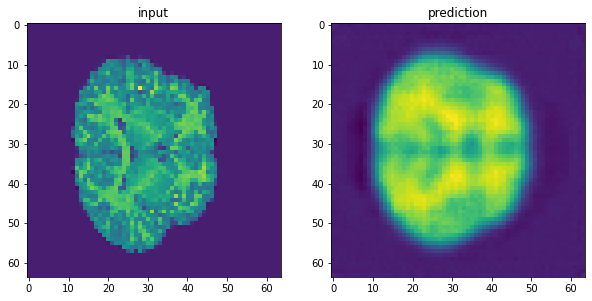

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(adhd_batch[0,:,:,32])
plt.title('input')
plt.subplot(1,2,2)
plt.imshow(predictions[0][0,:,:,32,0])
plt.title('prediction')

In [26]:
batch_loss = cvae.train_on_batch([adhd_batch,td_batch])

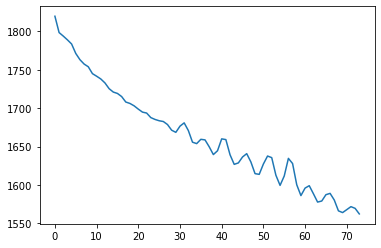

In [28]:
from matplotlib import pyplot as plt
plt.plot(loss)

In [31]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

In [34]:
# Save the weights
cvae.save_weights('/mmfs1/data/bergerar/tf_weightsAB/cvae_weights') 
